In [1]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, explained_variance_score, max_error
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping

import joblib 

In [2]:
df = pd.read_csv('data/synthetic_rul_v5.csv', sep=';', encoding='utf-8')
seq_len =24
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)
df = df.sort_values(['equipment_id','timestamp']).copy()

In [3]:
sensor_columns = ['temperature', 'pressure', 'vibration']
for col in sensor_columns:
    df[col] = df[col].astype('str').replace(',','.').astype(float)
    

In [4]:
rolling_window = 5
for eq in df['equipment_id'].unique():
    eq_idx = df['equipment_id'] == eq
    eq_data = df.loc[eq_idx, sensor_columns]

    # Rolling mean
    roll_mean = eq_data.rolling(rolling_window, min_periods=1).mean()
    roll_mean.columns = [f'{c}_roll_mean' for c in sensor_columns]  # rename

    df.loc[eq_idx, roll_mean.columns] = roll_mean

    # Rolling std
    roll_std = eq_data.rolling(rolling_window, min_periods=1).std().fillna(0)
    roll_std.columns = [f'{c}_roll_std' for c in sensor_columns]  # rename

    df.loc[eq_idx, roll_std.columns] = roll_std

    # Lag features
    for lag in range(1, 4):
        lag_df = eq_data.shift(lag).fillna(eq_data.mean())
        lag_df.columns = [f'{c}_lag{lag}' for c in sensor_columns]  # rename
        df.loc[eq_idx, lag_df.columns] = lag_df

df['vibration_slope'] = df.groupby('equipment_id')['vibration_roll_mean'].transform(lambda x: x.diff().fillna(0))
df['vibration_min']   = df.groupby('equipment_id')['vibration_roll_mean'].transform(lambda x: x.rolling(24, min_periods=1).min())
df['vibration_max']   = df.groupby('equipment_id')['vibration_roll_mean'].transform(lambda x: x.rolling(24, min_periods=1).max())
df['vibration_std']   = df.groupby('equipment_id')['vibration_roll_mean'].transform(lambda x: x.rolling(24, min_periods=1).std().fillna(0))
    

In [5]:
num_df = df.select_dtypes(include=[np.number])
corr = num_df.corr()
print(corr["RUL"].sort_values())

temperature             -0.795238
vibration               -0.792003
temperature_lag1        -0.734451
vibration_lag1          -0.731776
temperature_roll_mean   -0.723855
vibration_roll_mean     -0.723523
pressure                -0.711975
pressure_roll_mean      -0.703737
pressure_lag1           -0.688231
temperature_lag2        -0.675042
vibration_lag2          -0.672226
pressure_lag2           -0.663538
pressure_lag3           -0.637693
temperature_lag3        -0.616835
vibration_lag3          -0.614344
vibration_min           -0.584946
vibration_slope         -0.335561
failure_event           -0.191952
counter_value           -0.075925
vibration_max            0.104576
vibration_roll_std       0.352461
temperature_roll_std     0.358227
pressure_roll_std        0.411267
vibration_std            0.604618
RUL                      1.000000
operating_state               NaN
Name: RUL, dtype: float64


In [6]:
engineered_features = [
    # Raw signals
    'temperature', 'vibration', 'pressure',

    # Rolling means (short-term smoothing)
    'temperature_roll_mean', 'vibration_roll_mean', 'pressure_roll_mean',

    # Lag features (temporal dependencies)
    'temperature_lag1', 'vibration_lag1', 'pressure_lag1',
    'temperature_lag2', 'vibration_lag2', 'pressure_lag2',
    'temperature_lag3', 'vibration_lag3', 'pressure_lag3',

    # Variability (very predictive for failures)
    'temperature_roll_std', 'vibration_roll_std', 'pressure_roll_std',

    # Long-window degradation indicators
    'vibration_min', 'vibration_max', 'vibration_std', 'vibration_slope',

    # Events
    'failure_event'
]

In [7]:
df = df.sort_values(['equipment_id', 'timestamp']).reset_index(drop=True)

X, y = [], []
for eq in df['equipment_id'].unique():
    eq_data = df[df['equipment_id'] == eq][engineered_features].values
    rul = df[df['equipment_id'] == eq]['RUL'].values
    if len(eq_data) <= seq_len:
        continue
    split_idx = int(len(eq_data) * 0.8)  # 80% train, 20% val per equipment
     # Training sequences
    for i in range(split_idx - seq_len):
        X.append(eq_data[i:i+seq_len])
        y.append(rul[i+seq_len-1])
X_train = np.array(X)
y_train = np.array(y)

X_val, y_val = [], []
for eq in df['equipment_id'].unique():
    eq_data = df[df['equipment_id'] == eq][engineered_features].values
    rul = df[df['equipment_id'] == eq]['RUL'].values
    if len(eq_data) <= seq_len:
        continue

    split_idx = int(len(eq_data) * 0.8)
    for i in range(split_idx, len(eq_data) - seq_len):
        X_val.append(eq_data[i:i+seq_len])
        y_val.append(rul[i+seq_len-1])
X_val = np.array(X_val)
y_val = np.array(y_val)


# Scale features (fit on training data only)
num_samples, seq_len, num_features = X_train.shape
X_train_2d = X_train.reshape(num_samples * seq_len, num_features)
scaler = StandardScaler()
X_train_2d = scaler.fit_transform(X_train_2d)
X_train = X_train_2d.reshape(num_samples, seq_len, num_features)
joblib.dump(scaler, 'scaler.save')

X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Scale validation data
num_val_samples = X_val.shape[0]
X_val_2d = X_val.reshape(num_val_samples * seq_len, num_features)
X_val_2d = scaler.transform(X_val_2d)
X_val = X_val_2d.reshape(num_val_samples, seq_len, num_features)

In [8]:
model = Sequential([
        LSTM(128, return_sequences=True),
        LSTM(64, return_sequences=True),
        Dropout(0.1),
        LSTM(32),
        Dropout(0.1),
        Dense(1)
    ])
model.compile(optimizer='adam', loss='mse')

In [9]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=16,
    callbacks=[early_stop]
)
model.save('rul_lstm_model.keras')

Epoch 1/20

2425/2425 [==============================] - 37s 14ms/step - loss: 515.0539 - val_loss: 136.5701
Epoch 2/20
2425/2425 [==============================] - 30s 13ms/step - loss: 66.8884 - val_loss: 14.0908
Epoch 3/20
2425/2425 [==============================] - 31s 13ms/step - loss: 21.9865 - val_loss: 9.3814
Epoch 4/20
2425/2425 [==============================] - 32s 13ms/step - loss: 16.3251 - val_loss: 5.6906
Epoch 5/20
2425/2425 [==============================] - 31s 13ms/step - loss: 13.2414 - val_loss: 4.1599
Epoch 6/20
2425/2425 [==============================] - 31s 13ms/step - loss: 12.3712 - val_loss: 3.9146
Epoch 7/20
2425/2425 [==============================] - 31s 13ms/step - loss: 11.7466 - val_loss: 3.8187
Epoch 8/20
2425/2425 [==============================] - 31s 13ms/step - loss: 11.2751 - val_loss: 3.9685
Epoch 9/20
2425/2425 [==============================] - 34s 14ms/step - loss: 10.6459 - val_loss: 3.4694
Epoch 10/20
2425/2425 [===========================

In [10]:
y_pred = model.predict(X_val, verbose=0).flatten()
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

medae = median_absolute_error(y_val, y_pred)          # median absolute error
evs = explained_variance_score(y_val, y_pred)         # explained variance
max_err = max_error(y_val, y_pred)                   # worst-case error

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")
print(f"Median AE: {medae:.2f}")
print(f"Explained Variance: {evs:.2f}")
print(f"Max Error: {max_err:.2f}")

MSE: 2.99
RMSE: 1.73
MAE: 1.25
R²: 0.99
Median AE: 0.96
Explained Variance: 0.99
Max Error: 11.84


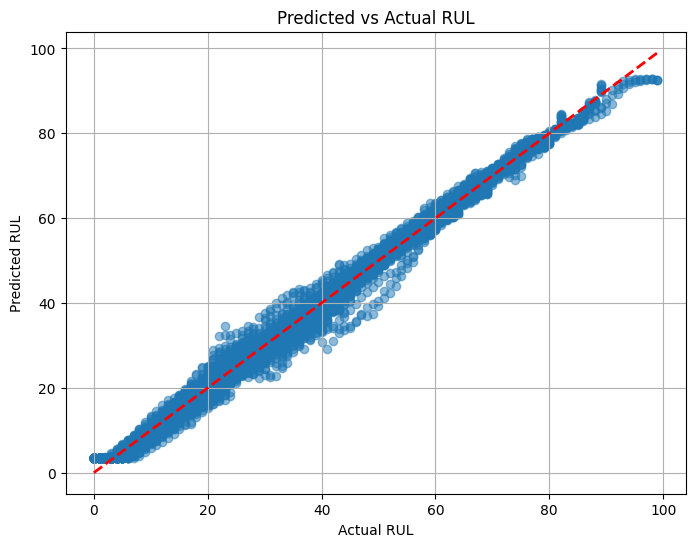

In [11]:
# Plot Predicted vs Actual
plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Predicted vs Actual RUL')
plt.grid(True)
plt.show()

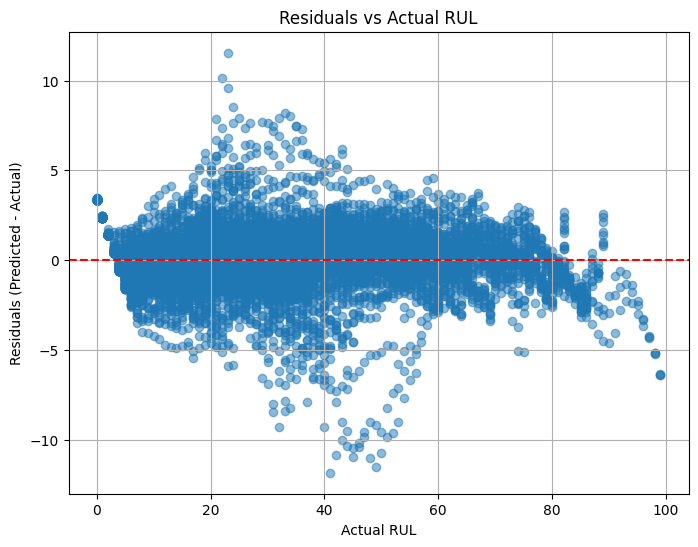

In [12]:
# Residuals
residuals = y_pred - y_val
# Plot Residuals
plt.figure(figsize=(8,6))
plt.scatter(y_val, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Actual RUL')
plt.ylabel('Residuals (Predicted - Actual)')
plt.title('Residuals vs Actual RUL')
plt.grid(True)
plt.show()